# WT partial differential equation

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the KdV equation. 

In [85]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
import colorcet as cc
import pandas as pd
from iteration_utilities import deepflatten

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import Siren
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.constraint import LeastSquares, GradParams, Ridge
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from deepymod.analysis import load_tensorboard

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)

# Configuring GPU or CPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)
#device = "cpu"

def write_model_expression(model_estimator_coeffs, poly_order=2, diff_order=3, latex=False):
    poly_order_it_array = range(1,poly_order+1)
    diff_order_it_array = range(1,diff_order+1)
    poly_terms = ['1']
    diff_terms = ['1']
    diff_term = 'u_{'
    for diff_order_it in diff_order_it_array:
        diff_term = diff_term + 'x'
        full_diff_term = diff_term +'}'
        diff_terms.append(full_diff_term)
    for poly_order_it in poly_order_it_array:
        if poly_order_it==1:
            poly_term = 'u'
        else:
            poly_term = 'u^{' + str(poly_order_it)+'}'
        poly_terms.append(poly_term)
    function_coeffs_list = library_matrix_mat(poly_terms, diff_terms)
    print('all tested functions list:')
    print(function_coeffs_list)
    print('--------------------------------------------------------')
    print('Inferred equation:')
    PDE_string = print_PDE(model_estimator_coeffs, function_coeffs_list, PDE_term='u_t')
    if latex is True:
        PDE_string = '$' + PDE_string + '$'
    return PDE_string

def library_matrix_mat(u, v, latex=False):
    '''
    Implements the matrix multiplication for strings and flattens it,
    mimicking how the library is made.
    Set latex=True to obtain latex forms.
    '''
    comp_list = []
    for u_element in u:
        for v_element in v:
            if ((u_element == '1') and ('v_element' == '1')):
                result = '1'
            elif u_element == '1':
                result = v_element
            elif v_element == '1':
                result = u_element
            else:
                result = u_element + v_element
            comp_list.append(result)
    if latex is True:
        comp_list = list(map(lambda x: '$'+x+'$', comp_list))
    return comp_list


def print_PDE(sparse_vector, coeffs_list, PDE_term='u_t'):
    '''
    Prints PDE with non-zero components according to sparse_vector.
    Set PDE_term to different string for different equations.
    '''
    non_zero_idx = np.nonzero(sparse_vector)[0]
    PDE = PDE_term + ' = '
    for idx in non_zero_idx:
        if idx != 0:
            if np.sign(sparse_vector[idx]) == -1:
                PDE += ' - '
            else:
                PDE += ' + '
            PDE += '%.4f ' % np.abs(sparse_vector[idx]) + coeffs_list[idx]
        else:
            PDE += '%.4f ' % np.abs(sparse_vector[idx])  
    print(PDE)
    return PDE

def write_model_expression(model_estimator_coeffs, poly_order=2, diff_order=3, latex=False):
    poly_order_it_array = range(1,poly_order+1)
    diff_order_it_array = range(1,diff_order+1)
    poly_terms = ['1']
    diff_terms = ['1']
    diff_term = 'u_{'
    for diff_order_it in diff_order_it_array:
        diff_term = diff_term + 'x'
        full_diff_term = diff_term +'}'
        diff_terms.append(full_diff_term)
    for poly_order_it in poly_order_it_array:
        if poly_order_it==1:
            poly_term = 'u'
        else:
            poly_term = 'u^{' + str(poly_order_it)+'}'
        poly_terms.append(poly_term)
    function_coeffs_list = library_matrix_mat(poly_terms, diff_terms)
    print('all tested functions list:')
    print(function_coeffs_list)
    print('--------------------------------------------------------')
    print('Inferred equation:')
    PDE_string = print_PDE(model_estimator_coeffs, function_coeffs_list, PDE_term='u_t')
    if latex is True:
        PDE_string = '$' + PDE_string + '$'
    return PDE_string

def library_matrix_mat(u, v, latex=False):
    '''
    Implements the matrix multiplication for strings and flattens it,
    mimicking how the library is made.
    Set latex=True to obtain latex forms.
    '''
    comp_list = []
    for u_element in u:
        for v_element in v:
            if ((u_element == '1') and ('v_element' == '1')):
                result = '1'
            elif u_element == '1':
                result = v_element
            elif v_element == '1':
                result = u_element
            else:
                result = u_element + v_element
            comp_list.append(result)
    if latex is True:
        comp_list = list(map(lambda x: '$'+x+'$', comp_list))
    return comp_list


def print_PDE(sparse_vector, coeffs_list, PDE_term='u_t'):
    '''
    Prints PDE with non-zero components according to sparse_vector.
    Set PDE_term to different string for different equations.
    '''
    non_zero_idx = np.nonzero(sparse_vector)[0]
    PDE = PDE_term + ' = '
    for idx in non_zero_idx:
        if idx != 0:
            if np.sign(sparse_vector[idx]) == -1:
                PDE += ' - '
            else:
                PDE += ' + '
            PDE += '%.4f ' % np.abs(sparse_vector[idx]) + coeffs_list[idx]
        else:
            PDE += '%.4f ' % np.abs(sparse_vector[idx])  
    print(PDE)
    return PDE

def signal_space_derivative(signal_matrix : pd.DataFrame(),
                            nb_nx_points : int,average_window : int,
                            average_min_periods :int,
                            sigma_space :int,
                            rolling_average_type : str = 'gaussian'):
    signal_matrix_dx = signal_matrix.copy()
    nx_dx = signal_matrix_dx['nx'].iloc[:-1]
    signal_matrix_dx = signal_matrix_dx.diff()
    signal_matrix_dx['nx_delta'] = signal_matrix_dx['nx']*0.5
    for column in signal_matrix_dx.columns:
        signal_matrix_dx.loc[:,column] = signal_matrix_dx.loc[:,column]/signal_matrix_dx.loc[:,'nx']
    signal_matrix_dx.dropna(inplace=True)
    signal_matrix_dx.reset_index(drop=True, inplace=True)
    signal_matrix_dx['nx'] = nx_dx + signal_matrix_dx['nx_delta']
    signal_matrix_dx.drop(['nx_delta'], axis=1, inplace=True)
    min_nx_dx = signal_matrix_dx['nx'].min()
    max_nx_dx = signal_matrix_dx['nx'].max()
    nx_dx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
    signal_matrix_dx_averaged = pd.DataFrame()
    signal_matrix_dx_averaged['nx'] = nx_dx_linearized
    signal_matrix_dx_averaged_temporal = signal_matrix_dx.copy()
    signal_matrix_dx_averaged_temporal.drop(['nx'], axis=1, inplace=True)
    for column in signal_matrix_dx_averaged_temporal.columns:
        ny = np.interp(nx_dx_linearized,signal_matrix_dx['nx'],signal_matrix_dx_averaged_temporal[column])
        signal_matrix_dx_averaged[column] = ny
        signal_matrix_dx_averaged[column] = signal_matrix_dx_averaged[column].rolling(window = average_window,
                                                                                           min_periods = average_min_periods,
                                                                                           win_type = rolling_average_type).mean(std = sigma_space)
    signal_matrix_dx_averaged['nx'] = signal_matrix_dx_averaged.loc[:,'nx'].rolling(window = average_window, min_periods = average_min_periods, center=True).mean()
    signal_matrix_dx_averaged = signal_x_common_base(signal_matrix_dx_averaged,'nx',
                                                     signal_matrix_dx_averaged['nx'].min(),
                                                     signal_matrix_dx_averaged['nx'].max(),
                                                     nb_nx_points)
    return signal_matrix_dx_averaged

def signal_time_derivative(signal_matrix : pd.DataFrame(),
                           nb_dt_points : int,
                           average_window : int,
                           average_min_periods : int,
                           sigma_time : int,
                           rolling_average_type : str = 'gaussian'):
    # time derivative
    signal_matrix_dt = signal_matrix.copy()
    nt_dt = signal_matrix_dt['nt'].iloc[:-1]
    nt_dt.reset_index(drop=True, inplace=True)
    signal_matrix_dt = signal_matrix_dt.diff()
    signal_matrix_dt['nt_delta'] = signal_matrix_dt['nt'] * 0.5
    for column in signal_matrix_dt.columns:
        signal_matrix_dt.loc[:,column] = signal_matrix_dt.loc[:,column]/signal_matrix_dt.loc[:,'nt']
    signal_matrix_dt.dropna(inplace=True)
    signal_matrix_dt.reset_index(drop=True, inplace=True)
    signal_matrix_dt['nt'] = nt_dt + signal_matrix_dt['nt_delta']
    signal_matrix_dt.drop(['nt_delta'], axis=1, inplace=True)
    min_nt_dt = signal_matrix_dt['nt'].min()
    max_nt_dt = signal_matrix_dt['nt'].max()
    nt_dt_linearized = np.linspace(min_nt_dt, max_nt_dt, nb_dt_points)
    signal_matrix_dt_averaged = pd.DataFrame()
    signal_matrix_dt_averaged_temporal = signal_matrix_dt.copy()
    signal_matrix_dt_averaged_temporal.drop(['nt'], axis=1, inplace=True)
    signal_matrix_dt_averaged['nt'] = nt_dt_linearized
    for column in signal_matrix_dt_averaged_temporal.columns:
        ny = np.interp(nt_dt_linearized,signal_matrix_dt['nt'],signal_matrix_dt_averaged_temporal[column])
        signal_matrix_dt_averaged[column] = ny
        signal_matrix_dt_averaged[column] = signal_matrix_dt_averaged[column].rolling(window = average_window,
                                                                                           min_periods = average_min_periods,
                                                                                           win_type = rolling_average_type).mean(std = sigma_time)
    signal_matrix_dt_averaged['nt'] = signal_matrix_dt_averaged.loc[:,'nt'].rolling(window = average_window,
                                                                                    min_periods = average_min_periods,
                                                                                    center=True).mean()
    signal_matrix_dt_averaged = signal_x_common_base(signal_matrix_dt_averaged,'nt',
                                                     signal_matrix_dt_averaged['nt'].min(),
                                                     signal_matrix_dt_averaged['nt'].max(),
                                                     nb_dt_points)
    return signal_matrix_dt_averaged

def signal_x_common_base(signal_matrix_space : pd.DataFrame(), ref_coordinates_column : str, min_nx_dx : float, max_nx_dx : float, nb_nx_points : int):
    signal_matrix_interpolated_temporal = signal_matrix_space.copy()
    nx_dx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
    signal_matrix_interpolated = pd.DataFrame()
    signal_matrix_interpolated[ref_coordinates_column] = nx_dx_linearized
    signal_matrix_interpolated_temporal.drop([ref_coordinates_column], axis=1, inplace=True)
    for column in signal_matrix_interpolated_temporal.columns:
        ny = np.interp(nx_dx_linearized, signal_matrix_space[ref_coordinates_column], signal_matrix_interpolated_temporal[column])
        signal_matrix_interpolated[column] = ny
    return signal_matrix_interpolated


def signal_t_common_base(signal_matrix_time : pd.DataFrame(), ref_coordinates_column : str, min_nt_dt : float, max_nt_dt : float, nb_nx_points : int):
    signal_matrix_interpolated_temporal = signal_matrix_time.copy()
    nt_dt_linearized = np.linspace(min_nt_dt, max_nt_dt, nb_nt_points)
    signal_matrix_interpolated = pd.DataFrame()
    signal_matrix_interpolated[ref_coordinates_column] = nt_dt_linearized
    signal_matrix_interpolated_temporal.drop([ref_coordinates_column], axis=1, inplace=True)
    for column in signal_matrix_interpolated_temporal.columns:
        ny = np.interp(nt_dt_linearized, signal_matrix_time[ref_coordinates_column], signal_matrix_interpolated_temporal[column])
        signal_matrix_interpolated[column] = ny
    return signal_matrix_interpolated


def plot_signal_space_derivative_fixed_time(signal_matrix_space : pd.DataFrame(),ref_time_label_df : pd.DataFrame(), quantity : str, derivative_label : str,   angle : float,
                                            start_frame: int, end_frame : int, delta_t : int, chi_threshold : float,
                                            plot_factor : float, ratio : float, axes_limitis_manual = False, y_min_manual = False, y_max_manual = False, FIGURES_DIR = ''):
    figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
    angle = np.round(angle, decimals = 3)
    label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
    title = 'signal ' + quantity + ', '+ label
    cmap = cc.cm.CET_CBTL2
    colors = cmap(np.linspace(0,1,int((end_frame  - start_frame + 1) / delta_t)))
    for time_frame,color in zip(range(start_frame,end_frame ,delta_t),colors):
            frame = 't' + str(time_frame)
            signal = signal_matrix_space.loc[:,signal_matrix_space.columns.str.endswith(frame) | signal_matrix_space.columns.str.contains('nx')].copy()
            signal = signal[(signal['nx']>chi_threshold)]
            plt.plot(signal['nx'], signal[quantity+'_r_avrg_'+ frame],c=color,label = ref_time_label_df.iloc[time_frame]['time_label']+' APF')
    plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
    ax.set(xlabel = r'$\chi$', ylabel = r'$ %s \equiv F(\chi|t)$' % derivative_label)
    if axes_limitis_manual:
        ax.set_ylim(y_min_manual, y_max_manual)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
    plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
    ax.legend(loc='center left', bbox_to_anchor=(0.81, 0.5))
    if FIGURES_DIR != '':
        plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
    plt.show()

def plot_signal_time_derivative_fixed_space(signal_matrix_time : pd.DataFrame(),ref_space_label_df : pd.DataFrame(), quantity : str, derivative_label : str,   angle : float,
                                            start_chi_column: int, end_chi_column : int, delta_chi : int, t_threshold : float,
                                            plot_factor : float, ratio : float, axes_limitis_manual = False, y_min_manual = False, y_max_manual = False, FIGURES_DIR = ''):
    figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
    angle = np.round(angle, decimals = 3)
    label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
    title = 'signal ' + quantity + ', '+ label
    cmap = cc.cm.CET_CBTL2
    colors = cmap(np.linspace(0,1,int((end_chi_column  - start_chi_column + 1) / delta_chi)))
    for chi_column,color in zip(range(start_frame,end_frame ,delta_t),colors):
        signal = signal_matrix_time[(signal_matrix_time['nt']>t_threshold)]
        plt.plot(signal.loc[:,'nt'], signal.loc[:,chi_column],c=color,label = r'%s $\mu$' %str(np.round(ref_space_label_df.loc[chi_column,'nx'],decimals = 1)))
    plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
    ax.set(xlabel = r'$t(hAPF)$', ylabel = r'$ %s \equiv F(t|\chi)$' % derivative_label)
    if axes_limitis_manual:
        ax.set_ylim(y_min_manual, y_max_manual)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
    plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
    ax.legend(loc='center left', bbox_to_anchor=(0.81, 0.5))
    if FIGURES_DIR != '':
        plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
    plt.show()

cuda


Shape of grid x: (140, 176)
Shape of grid t: (140, 176)
Shape of grid u: (140, 176)


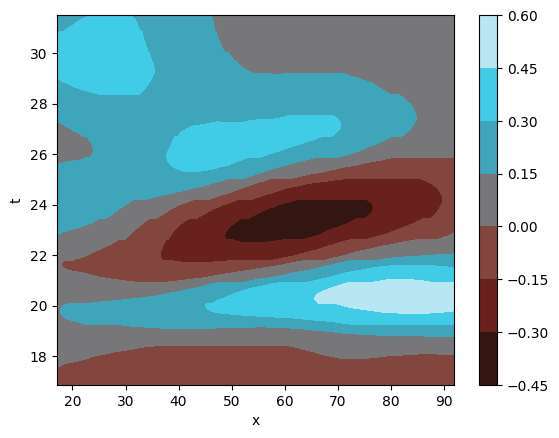

In [86]:
signal_data = pd.read_csv('dataset/signal_matrix_space_data.csv')
time_data = pd.read_csv('dataset/plot_time_label_df.csv')
x = signal_data['nx'].values
t = time_data['frame_in_hours'].values
t,x = np.meshgrid(t,x)
u_data = signal_data.copy()
u_data = u_data.drop(columns=['nx'])
u = np.real(u_data.to_numpy())*10
data = {}
data['x'] = x
print('Shape of grid x:', data['x'].shape)
data['t'] = t
print('Shape of grid t:', data['t'].shape)
data['u'] = u 
print('Shape of grid u:', data['u'].shape)

fig, ax = plt.subplots()
im = ax.contourf(data['x'], data['t'], data['u'], cmap=cc.cm.CET_CBTL2)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()


In [87]:
X = np.transpose((data['t'].flatten(), data['x'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))
print('X shape, y shape:', X.shape, y.shape)

X shape, y shape: (24640, 2) (24640, 1)


In [88]:
noise_level = 0.025
y_noisy = y + noise_level * np.std(y) * np.random.randn(y[:,0].size, 1)
#coords = torch.from_numpy(np.stack((t.tolist(),x.tolist()), axis=-1)).float()
#X = coords
#y = u

In [89]:
number_of_samples = 5000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)
print(X_train.shape, y_train.shape)

torch.Size([5000, 2]) torch.Size([5000, 1])


In [90]:
len(idx)

24640

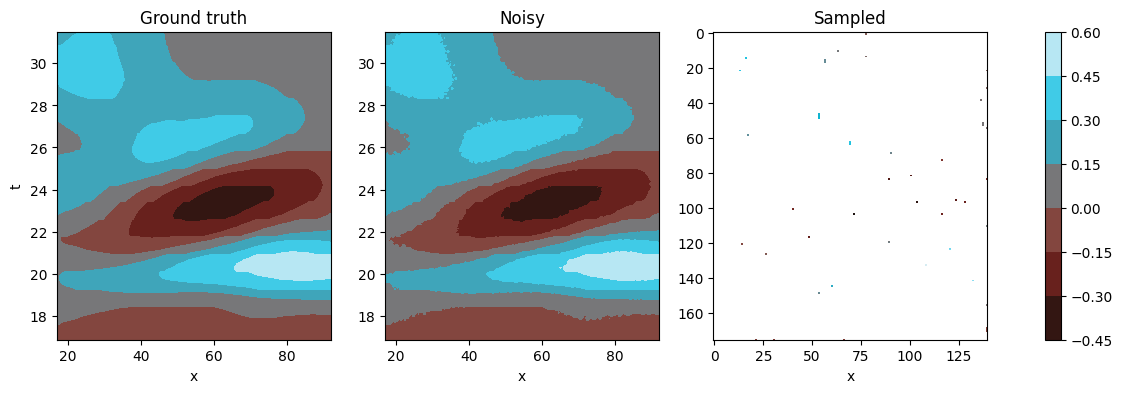

In [91]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap=cc.cm.CET_CBTL2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap=cc.cm.CET_CBTL2)
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap=cc.cm.CET_CBTL2)
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

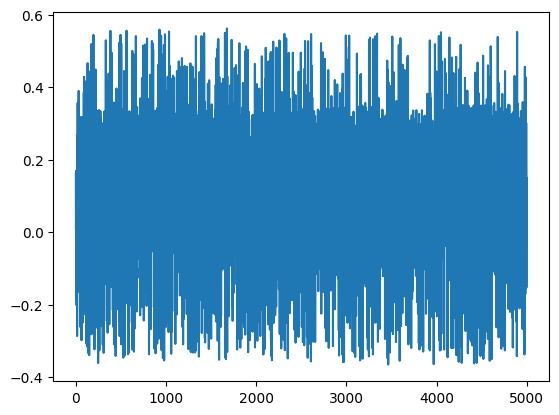

In [92]:
plt.plot(y_train)

Before we send the data into the Dataset format, create a plot to get an idea of the data:

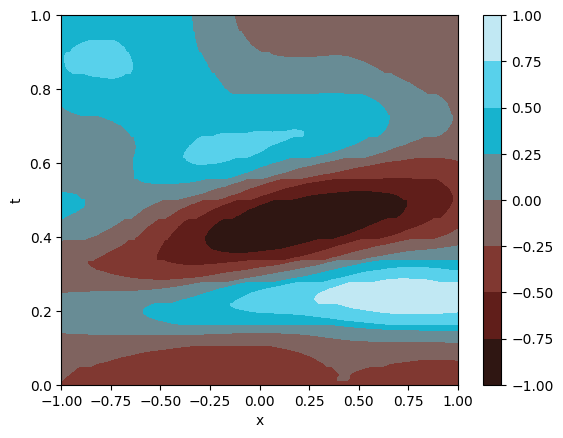

In [147]:
x = np.real(signal_data['nx'].values)
t = time_data['frame_in_hours'].values
signal_data = pd.read_csv('dataset/signal_matrix_space_data.csv')
x = np.real(signal_data['nx'].values)
t = time_data['frame_in_hours'].values
#t_min = int(30)
#t_max = int(115)
u_data = signal_data.copy()
u_data = u_data.drop(columns=['nx'])
#u_data = u_data.iloc[:,t_min:t_max]
#t = np.real(t[t_min:t_max])
t = np.real(t)
u_data_test = (u_data - u_data.min().min())/(u_data.max().max() - u_data.min().min())*2-1
x_data_test = x
x_data_test = (x_data_test - x_data_test.min())/(x_data_test.max() - x_data_test.min())*2-1
t_data_test = t
t_data_test = (t_data_test - t_data_test.min())/(t_data_test.max() - t_data_test.min())
t_data_test,x_data_test = np.meshgrid(t_data_test,x_data_test)
u = np.real(u_data_test.to_numpy())
fig, ax = plt.subplots()
im = ax.contourf(x_data_test, t_data_test, u_data_test, cmap=cc.cm.CET_CBTL2)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()


We can now define a function that loads the data, makes torch tensors out of it and then returns it in a coords, data format. The shape of the samples will be (t,x) for the input and (u) for the dataset. Ensure that any array is not 1D, so an array with a single feature can be the shape (N,1) using reshape(-1,1) in numpy or unsqueeze(-1) in torch.

In [148]:
def load_data():
    coords = torch.from_numpy(np.stack((t_data_test.tolist(),x_data_test.tolist()), axis=-1)).float()
    data = torch.from_numpy(u).unsqueeze(-1).float()
    return coords, data

In [149]:
dataset = Dataset(
    load_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 5000},
    device=device,
)

Dataset is using device:  cuda


We now also wish to split the data into a train and test split, specifically into loaders, which handle the logic of passing the samples to the model.

In [150]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.


In [151]:
network = Siren(2, [50, 50, 50, 50, 50, 50, 50, 50], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [152]:
library = Library1D(poly_order=2, diff_order=3) 

In [99]:
from deepymod.model.library import library_poly
from deepymod.model.library import library_deriv
library_poly = library_poly(y_train,2)
#library_deriv = library_deriv(load_data_test[0],load_data_test[1],3)

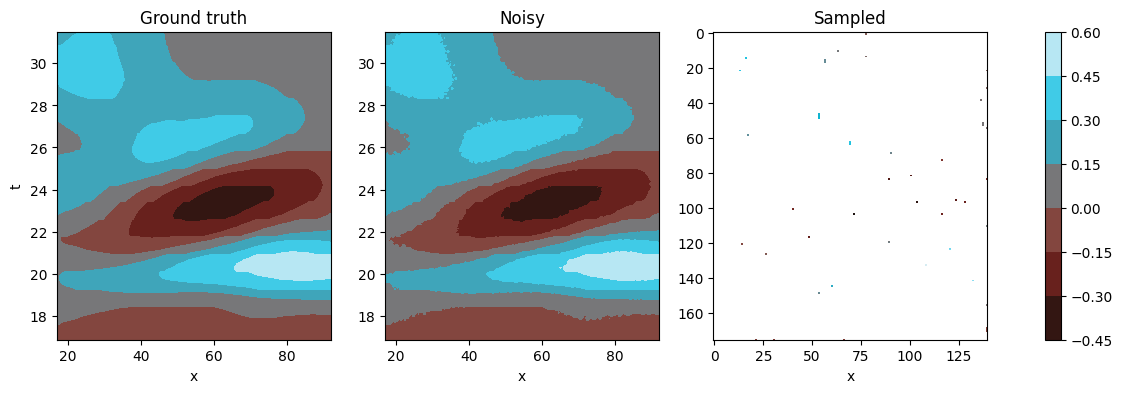

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap=cc.cm.CET_CBTL2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap=cc.cm.CET_CBTL2)
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap=cc.cm.CET_CBTL2)
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged. 

In [153]:
#estimator = Threshold(0.1)
estimator = PDEFIND()
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5)

Configuration of the sparsity estimator

In [154]:
constraint = GradParams(12,1)
#GradParams()model.parameters()
#Ridge()
# Configuration of the sparsity scheduler

In [155]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.999, 0.999), amsgrad=True, lr=1e-5)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data:

- The directory where the tensorboard file is written (log_dir)
- The ratio of train/test set used (split)
- The maximum number of iterations performed (max_iterations)
- The absolute change in L1 norm considered converged (delta)
- The amount of epochs over which the absolute change in L1 norm is calculated (patience)



In [156]:
train(model, train_dataloader, test_dataloader, optimizer, sparsity_scheduler, log_dir='runs/test_08_bis/', split=0.8, max_iterations=200000)

  2200  MSE: 1.73e-01  Reg: 8.46e-04  L1: 7.21e-01 Algorithm converged. Writing model to disk.


In [157]:
model_sparsity_masks = model.sparsity_masks

In [158]:
model_estimator_coeffs = model.estimator_coeffs()

There's two groups: the model.estimator_coeffs() are the coefficients as returned by the sparsity estimator, and are always normalized. The model.constraint_coeffs() return the coefficients as calculated by the constraint through least squares typically. scaled sets if theyre normalized, sparse sets if you also want the zeros returned.

In [159]:
print(model_estimator_coeffs[0])

[[ 0.        ]
 [-0.4082098 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.52693796]
 [ 0.        ]
 [ 0.        ]]


In [160]:
PDE_string = write_model_expression(model_estimator_coeffs[0], poly_order=2, diff_order=3, latex=False)

all tested functions list:
['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u', 'uu_{x}', 'uu_{xx}', 'uu_{xxx}', 'u^{2}', 'u^{2}u_{x}', 'u^{2}u_{xx}', 'u^{2}u_{xxx}']
--------------------------------------------------------
Inferred equation:
u_t =  - 0.4082 u_{x} + 0.5269 u^{2}u_{x}


In [161]:
model_constraint_coeffs = model.constraint_coeffs()

In [162]:
print(model_constraint_coeffs)

[tensor([[-0.0000],
        [-1.0494],
        [ 0.0000],
        [-0.0000],
        [ 0.0000],
        [-0.0000],
        [-0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.1677],
        [-0.0000],
        [-0.0000]], device='cuda:0', grad_fn=<MulBackward0>)]


In [137]:
solution = model(train_dataloader[0][0])[0].cpu().detach().numpy()
data_x = train_dataloader[0][0].cpu().detach().numpy().squeeze()
sampled = np.rot90(solution.reshape(x.shape)) #array needs to be rotated because of imshow

#im2 = axes[2].imshow(sampled, aspect='auto', cmap=cc.cm.CET_CBTL2)

ValueError: cannot reshape array of size 4000 into shape (140,)

In [138]:
140*85

11900

## Analysing

In [163]:
# right now works with file path, will change to experiment_ID 
df =  load_tensorboard('runs/test_08_bis/')

In [164]:
df.head()

,estimator_coeffs_output_0,loss_mse_output_0,coeffs_output_0_coeff_0,coeffs_output_0_coeff_1,coeffs_output_0_coeff_10,coeffs_output_0_coeff_11,coeffs_output_0_coeff_2,coeffs_output_0_coeff_3,coeffs_output_0_coeff_4,coeffs_output_0_coeff_5,...,estimator_coeffs_output_0_coeff_11,estimator_coeffs_output_0_coeff_2,estimator_coeffs_output_0_coeff_3,estimator_coeffs_output_0_coeff_4,estimator_coeffs_output_0_coeff_5,estimator_coeffs_output_0_coeff_6,estimator_coeffs_output_0_coeff_7,estimator_coeffs_output_0_coeff_8,estimator_coeffs_output_0_coeff_9,loss_l1_output_0
0,0.0,0.258488,-0.271054,0.300824,-0.283676,-0.196613,-0.101221,-0.092129,0.665909,-0.302107,...,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,3.433664
25,0.0,0.254310,0.152762,-1.629006,-0.493324,-0.313394,-0.253515,-0.635527,-0.280316,2.973900,...,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,9.889288
50,0.0,0.250579,-0.026722,-0.180120,0.231741,0.723740,0.025672,0.318962,0.208434,0.303006,...,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,3.546146
75,0.0,0.248337,0.137285,0.368677,0.135112,0.256765,-0.070752,0.110163,-0.285867,-0.567662,...,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,2.782703
100,0.0,0.246821,0.415284,0.342676,0.086312,-0.214749,0.259687,0.130906,0.776474,0.430245,...,-0.11047,0.0,0.11115,0.0,0.0,0.0,0.0,0.0,0.0,3.673188


In [165]:
df.keys()

Index(['estimator_coeffs_output_0', 'loss_mse_output_0',
       'coeffs_output_0_coeff_0', 'coeffs_output_0_coeff_1',
       'coeffs_output_0_coeff_10', 'coeffs_output_0_coeff_11',
       'coeffs_output_0_coeff_2', 'coeffs_output_0_coeff_3',
       'coeffs_output_0_coeff_4', 'coeffs_output_0_coeff_5',
       'coeffs_output_0_coeff_6', 'coeffs_output_0_coeff_7',
       'coeffs_output_0_coeff_8', 'coeffs_output_0_coeff_9',
       'loss_reg_output_0', 'unscaled_coeffs_output_0_coeff_0',
       'unscaled_coeffs_output_0_coeff_1', 'unscaled_coeffs_output_0_coeff_10',
       'unscaled_coeffs_output_0_coeff_11', 'unscaled_coeffs_output_0_coeff_2',
       'unscaled_coeffs_output_0_coeff_3', 'unscaled_coeffs_output_0_coeff_4',
       'unscaled_coeffs_output_0_coeff_5', 'unscaled_coeffs_output_0_coeff_6',
       'unscaled_coeffs_output_0_coeff_7', 'unscaled_coeffs_output_0_coeff_8',
       'unscaled_coeffs_output_0_coeff_9', 'estimator_coeffs_output_0_coeff_1',
       'estimator_coeffs_output_0_

Text(0.5, 1.0, 'Regression')

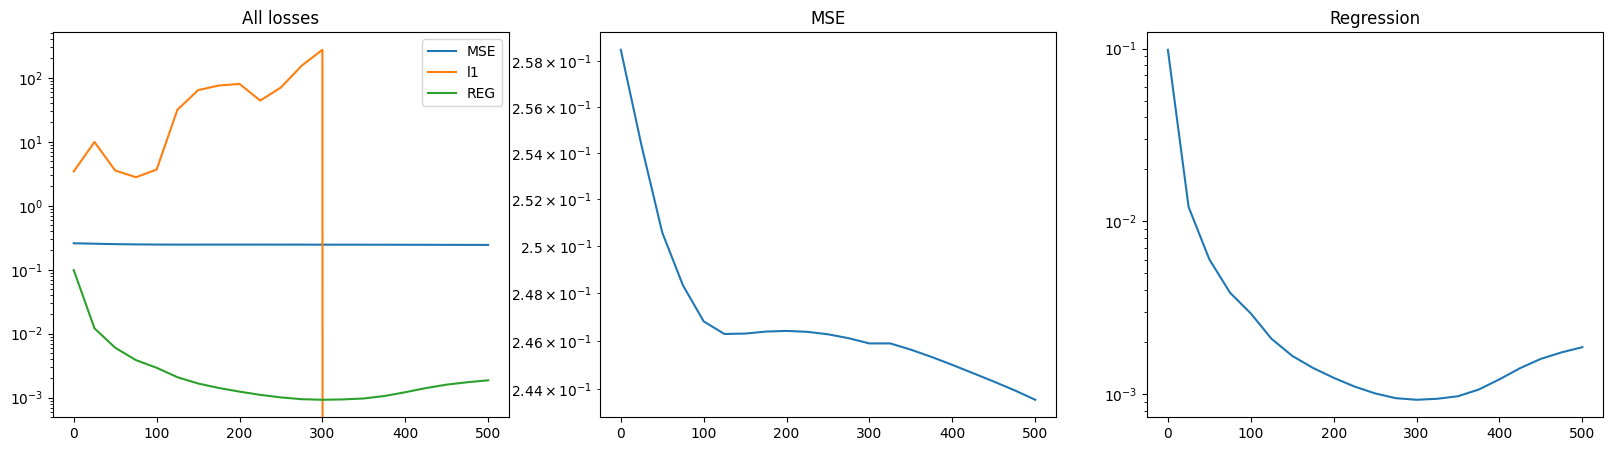

In [166]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.semilogy(df.index, df['loss_mse_output_0'], label='MSE')
plt.semilogy(df.index, df['loss_l1_output_0'], label='l1')
plt.semilogy(df.index, df['loss_reg_output_0'], label='REG')
plt.title('All losses')
plt.legend()

plt.subplot(132)
plt.semilogy(df.index, df['loss_mse_output_0'], label='MSE')
plt.title('MSE')

plt.subplot(133)
plt.semilogy(df.index, df['loss_reg_output_0'], label='PI')
plt.title('Regression')

In [167]:
coeff_keys = [key for key in df.keys() if key[:5]=='coeff']
print(coeff_keys)

['coeffs_output_0_coeff_0', 'coeffs_output_0_coeff_1', 'coeffs_output_0_coeff_10', 'coeffs_output_0_coeff_11', 'coeffs_output_0_coeff_2', 'coeffs_output_0_coeff_3', 'coeffs_output_0_coeff_4', 'coeffs_output_0_coeff_5', 'coeffs_output_0_coeff_6', 'coeffs_output_0_coeff_7', 'coeffs_output_0_coeff_8', 'coeffs_output_0_coeff_9']


Text(0.5, 1.0, 'Coefficients')

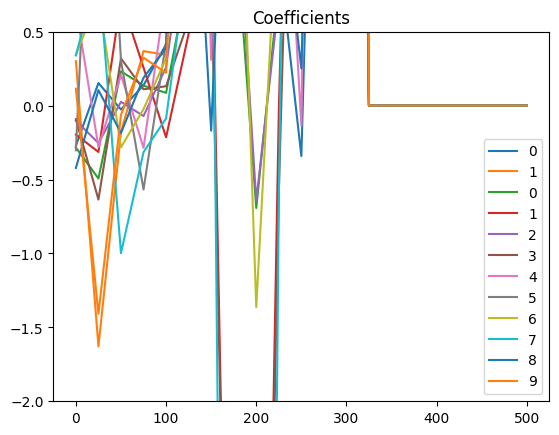

In [168]:
for key in coeff_keys:
    plt.plot(df[key], label=f'{key[-1]}')
plt.legend()
plt.ylim([-2, 0.5])
plt.title('Coefficients')

In [169]:
unscaled_coeff_keys = [key for key in df.keys() if key.__contains__('unscaled_coeffs_output')]
print(unscaled_coeff_keys)

['unscaled_coeffs_output_0_coeff_0', 'unscaled_coeffs_output_0_coeff_1', 'unscaled_coeffs_output_0_coeff_10', 'unscaled_coeffs_output_0_coeff_11', 'unscaled_coeffs_output_0_coeff_2', 'unscaled_coeffs_output_0_coeff_3', 'unscaled_coeffs_output_0_coeff_4', 'unscaled_coeffs_output_0_coeff_5', 'unscaled_coeffs_output_0_coeff_6', 'unscaled_coeffs_output_0_coeff_7', 'unscaled_coeffs_output_0_coeff_8', 'unscaled_coeffs_output_0_coeff_9']


Text(0.5, 1.0, 'Coefficients')

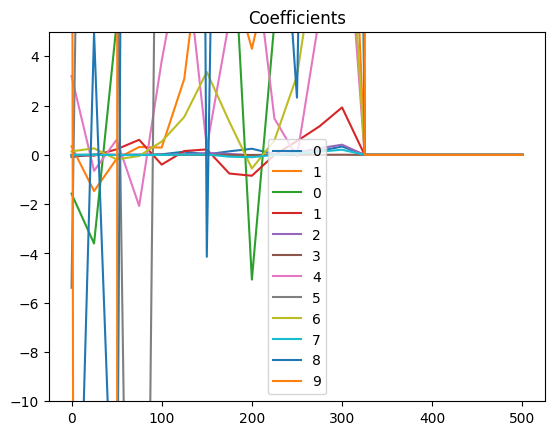

In [170]:
for key in unscaled_coeff_keys:
    plt.plot(df[key], label=f'{key[-1]}')
plt.legend()
plt.ylim([-10, 5])
plt.title('Coefficients')

In [172]:
# eqilibrate the matrix with data
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
signal_matrix_equilibrated = pd.read_csv('dataset/signal_matrix_equilibrated.csv')
plot_time_label_df = pd.read_csv('dataset/plot_time_label_df.csv')

In [173]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

signal_matrix_equilibrated_dx = signal_space_derivative(signal_matrix_equilibrated,160,20,1,15)
signal_matrix_equilibrated_dxdx = signal_space_derivative(signal_matrix_equilibrated_dx,160,20,1,15)
signal_matrix_equilibrated_dxdxdx = signal_space_derivative(signal_matrix_equilibrated_dxdx,160,20,1,15)
min_nx_dx = signal_matrix_equilibrated_dxdxdx['nx'].min()
max_nx_dx = signal_matrix_equilibrated_dxdxdx['nx'].max()
nb_nx_points = 140
signal_matrix_space = signal_x_common_base(signal_matrix_equilibrated,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dx = signal_x_common_base(signal_matrix_equilibrated_dx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dxdx = signal_x_common_base(signal_matrix_equilibrated_dxdx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dxdxdx = signal_x_common_base(signal_matrix_equilibrated_dxdxdx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)

signal_matrix_time = signal_matrix_space.copy()
signal_matrix_time_temporal_nx = signal_matrix_time['nx']
signal_matrix_time.drop(['nx'], axis=1, inplace=True)
signal_matrix_time = signal_matrix_time.T
signal_matrix_time.reset_index(drop=True, inplace=True)
signal_matrix_time['nt'] = plot_time_label_df.loc[:,'frame_in_hours'].values

signal_matrix_time_dt = signal_time_derivative(signal_matrix_time,160,20,1,9)
signal_matrix_time_dtdt = signal_time_derivative(signal_matrix_time_dt,160,20,1,9)
min_nt = signal_matrix_time_dtdt['nt'].min()
max_nt = signal_matrix_time_dtdt['nt'].max()
nb_nt_points = 160

signal_matrix_time_dt = signal_t_common_base(signal_matrix_time_dt, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_time_dt.drop(['nt'], axis=1, inplace=True)
signal_matrix_time_dt_transposed = signal_matrix_time_dt.T
signal_matrix_time_dt_transposed['nx'] = signal_matrix_time_temporal_nx
signal_matrix_time_dt_normal = signal_x_common_base(signal_matrix_time_dt_transposed,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_time_dt_normal.drop(['nx'], axis=1, inplace=True)

In [174]:
print('signal u_t shape')
print(signal_matrix_time_dt_normal.shape)
signal_matrix_space_dx_temporal = signal_matrix_space_dx.copy()
signal_matrix_space_dx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dx_temporal = signal_matrix_space_dx_temporal.T
signal_matrix_space_dx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dx_temporal = signal_t_common_base(signal_matrix_space_dx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dx_normal = signal_matrix_space_dx_temporal.T
print('signal u_x shape')
print(signal_matrix_space_dx_normal.shape)

signal_matrix_space_dxdx_temporal = signal_matrix_space_dxdx.copy()
signal_matrix_space_dxdx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dxdx_temporal = signal_matrix_space_dxdx_temporal.T
signal_matrix_space_dxdx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dxdx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dxdx_temporal = signal_t_common_base(signal_matrix_space_dxdx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dxdx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dxdx_normal = signal_matrix_space_dxdx_temporal.T
print('signal u_xx shape')
print(signal_matrix_space_dxdx_normal.shape)

signal_matrix_space_dxdxdx_temporal = signal_matrix_space_dxdxdx.copy()
signal_matrix_space_dxdxdx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dxdxdx_temporal = signal_matrix_space_dxdxdx_temporal.T
signal_matrix_space_dxdxdx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dxdxdx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dxdxdx_temporal = signal_t_common_base(signal_matrix_space_dxdxdx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dxdxdx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dxdxdx_normal = signal_matrix_space_dxdxdx_temporal.T
print('signal u_xxx shape')
print(signal_matrix_space_dxdxdx_normal.shape)


signal_matrix_space_temporal = signal_matrix_space.copy()
signal_matrix_space_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_temporal = signal_matrix_space_temporal.T
signal_matrix_space_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_temporal = signal_t_common_base(signal_matrix_space_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_normal = signal_matrix_space_temporal.T
print('signal u shape')
print(signal_matrix_space_normal.shape)
signal_matrix_space_square_normal = signal_matrix_space_normal**2
print('signal u^2 shape')
print(signal_matrix_space_normal.shape)

signal u_t shape
(140, 160)
signal u_x shape
(140, 160)
signal u_xx shape
(140, 160)
signal u_xxx shape
(140, 160)
signal u shape
(140, 160)
signal u^2 shape
(140, 160)


In [175]:
C_0 = df['coeffs_output_0_coeff_0'].iloc[-1]
print('C_0 = ', C_0)
C_1 = df['estimator_coeffs_output_0_coeff_2'].iloc[-1]
print('C_1 = ', C_1)
C_2 = df['coeffs_output_0_coeff_2'].iloc[-1]
print('C_2 = ', C_2)
C_3 = df['unscaled_coeffs_output_0_coeff_3'].iloc[-1]
print('C_3 = ', C_3)
C_4 = df['unscaled_coeffs_output_0_coeff_4'].iloc[-1]
print('C_4 = ', C_4)
C_5 = df['unscaled_coeffs_output_0_coeff_5'].iloc[-1]
print('C_5 = ', C_5)
C_6 = df['unscaled_coeffs_output_0_coeff_6'].iloc[-1]
print('C_6 = ', C_6)
C_7 = df['unscaled_coeffs_output_0_coeff_7'].iloc[-1]
print('C_7 = ', C_7)
C_8 = df['coeffs_output_0_coeff_8'].iloc[-1]
print('C_8 = ', C_8)
C_9 = df['unscaled_coeffs_output_0_coeff_9'].iloc[-1]
print('C_9 = ', C_9)
C_10 = df['unscaled_coeffs_output_0_coeff_10'].iloc[-1]
print('C_10 = ', C_10)
C_11 = df['unscaled_coeffs_output_0_coeff_11'].iloc[-1]
print('C_11 = ', C_11)

C_0 =  0.0
C_1 =  0.518920361995697
C_2 =  0.0
C_3 =  0.0
C_4 =  0.0
C_5 =  0.0
C_6 =  0.0
C_7 =  0.0
C_8 =  0.0
C_9 =  0.0
C_10 =  0.0
C_11 =  0.0


In [176]:
C_0 = 0.
C_1 = -1
C_2 = 0
C_3 = 0
C_4 = 0
C_5 = 0
C_6 = 0
C_7 = 0
C_8 = 0
C_9 = 0.16
C_10 = 0
C_11 = 0.0

In [177]:
signal_matrix_equation_normal = signal_matrix_space_dx_normal*C_1 + \
                                signal_matrix_space_dxdx_normal*C_2 + \
                                signal_matrix_space_dxdxdx_normal*C_3 + \
                                signal_matrix_space_normal*C_4 + \
                                signal_matrix_space_normal * signal_matrix_space_dx_normal*C_5 + \
                                signal_matrix_space_normal * signal_matrix_space_dxdx_normal* C_6 + \
                                signal_matrix_space_normal * signal_matrix_space_dxdxdx_normal* C_7 + \
                                signal_matrix_space_square_normal * C_8 +\
                                signal_matrix_space_square_normal * signal_matrix_space_dx_normal * C_9 + \
                                signal_matrix_space_square_normal * signal_matrix_space_dxdx_normal * C_10 + \
                                signal_matrix_space_square_normal * signal_matrix_space_dxdxdx_normal * C_11 + C_0

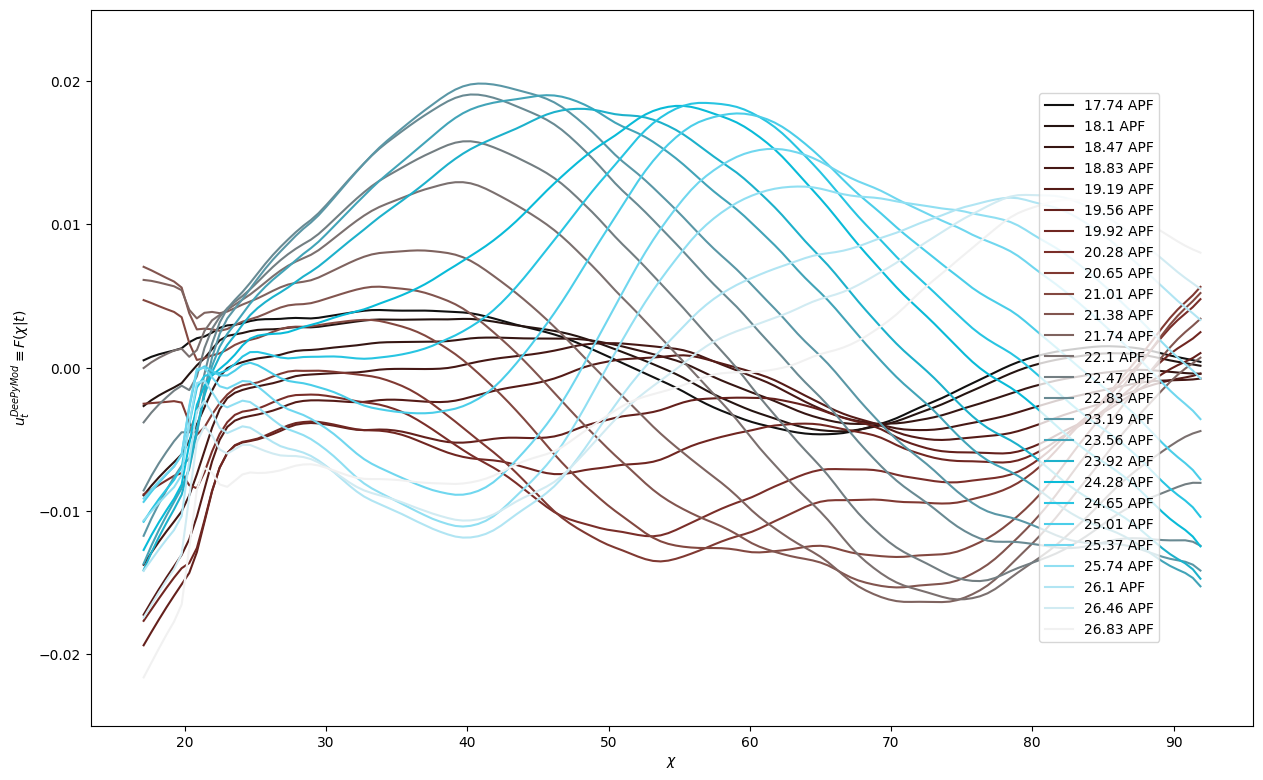

In [180]:
plot_factor = 2
ratio = 1
figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
signal_matrix_space_normal_to_plot = signal_matrix_equation_normal.copy()
nx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
nt_linearized = np.linspace(min_nt, max_nt, nb_nt_points)
signal_matrix_space_normal_to_plot['nx'] = nx_linearized
end_frame = 130
start_frame = 1
delta_t = 5
chi_threshold = 17
derivative_label = 'u^{DeePyMod}_t'
#angle = np.round(angle, decimals = 3)
#label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
#title = 'signal ' + quantity + ', '+ label
cmap = cc.cm.CET_CBTL2
colors = cmap(np.linspace(0,1,int((end_frame  - start_frame + 1) / delta_t)))
signal = signal_matrix_space_normal_to_plot.copy()
signal = signal[(signal['nx']>chi_threshold)]
for time_frame,color in zip(range(start_frame,end_frame ,delta_t),colors):
    plt.plot(signal['nx'], signal.loc[:,time_frame],c=color,label = str(np.round(nt_linearized[time_frame],decimals = 2))+' APF')
#plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
ax.set(xlabel = r'$\chi$', ylabel = r'$ %s \equiv F(\chi|t)$' % derivative_label)
#xleft, xright = ax.get_xlim()
#ybottom, ytop = ax.get_ylim()
#ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
#plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
ax.legend(loc='center left', bbox_to_anchor=(0.81, 0.5))
ax.set_ylim([-0.025, 0.025])
#if FIGURES_DIR != '':
#    plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
plt.show()